# Subject Data PreProcessing
* find subject data
* concatenate the inter-session data
* concatenate the intra-session data

## Configuration

In [1]:
# General configuration
import os

# data_directory: str
#     Path to a directory to store data.
data_directory = '.'

# install_missing_packages: bool
#     A flag indicating if missing packages should be automatically installed
install_missing_packages = True

# use_conda: bool
#     A flag indicating if conda should be used for software installation.
#     If False, pip will be used. The default is to use conda if jupyter
#     is run in a conda environment.
use_conda = 'CONDA_EXE' in os.environ

## Checking for missing packages

In [2]:
import importlib

def check_package(package, pip_pkg: str = None, conda_pkg: str = None):
    """Check if a given package is installed. If missing install
    it (if global flag `install_missing_packages` is True) either with
    pip or with conda (depending on `use_conda`).
    """
    if importlib.util.find_spec(package) is not None:
        return  # ok, package is already installed

    if not install_missing_packages:
        raise RuntimeError(f"{package} is not installed!")

    if use_conda:
        import conda.cli
        conda.cli.main('conda', 'install',  '-y', conda_pkg or package)
    else:
        import subprocess
        import sys            
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', pip_pkg or package])
        
# This is to exit cells without error tracebacks (cosmetic purpose)
class StopExecution(Exception):
    def _render_traceback_(self):
        pass

## Creating the required environment (skip if already done)

Running the following cell will create a file graphs.yml that can be used to setup a conda environment containing the required packages. If you already downloaded the file from my GitHub, skip the next cell and create the env directly from it.

In [4]:
%%writefile graphs.yml
name: graphs
channels:
  - conda-forge
  - defaults
dependencies:
  - python=3.6
  - jupyter
  - imageio
  - imageio-ffmpeg
  - matplotlib
  - scikit-image
  - opencv
  - networkx
  - pandas
  - statsmodels

Overwriting graphs.yml


### Environment Creation
To create the environment, open the terminal, go to the directory where you stored the graphs.yml file (the directory of the notebook) and type
conda env create -f graphs.yml
After running this command you have to activate the environment (Linux/MacOS: conda activate graphs, Windows: activate graphs) and then reopen the notebook in that environment.

## Main Part

### Imports and directory information

In [3]:
import os
import json
import numpy as np
import cv2 
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nX
import glob
import scipy.cluster.vq as clusters
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.preprocessing import normalize
from pandas.plotting import autocorrelation_plot as AC_plot 
from statsmodels.graphics import tsaplots
from statsmodels.tsa.stattools import acf
from skimage.filters import gaussian
from mpl_toolkits.mplot3d import Axes3D 


OG_DATA_PATH = './'
DATA_PATH = './Data Exploration/'

# Reset the Datapath since the data is not yet on Git, comment out if data is on Git 
DATA_PATH = '/Volumes/EXTENSION/Uni/Study Project/Data Exploration/'

PROCESSED_DATA_PATH = './Results/'
# Getting the Folder without hidden files in ascending order 
DATA_FOLDER = sorted([f for f in os.listdir(DATA_PATH) if not f.startswith('.')], key=str.lower)

### Extracting all subject IDs from the data folder

In [5]:
subIDs = []
for sub in DATA_FOLDER:
    subIDs.append(int(sub[0:4]))
subIDs = np.unique(subIDs)
print(subIDs)

[1023]


### Combine the data
* Loop through all subjects
* extract the session data
* combine the data
* save it

In [135]:
#for subject in subIDs:
subject = subIDs[0] # change with the loop

# extract the exploration data
subject_data = sorted([f for f in DATA_FOLDER if f.startswith(str(subject)+'_Expl_')], key=str.lower)


# column name list 
col_names =  ['timeStampDataPointStart','timeStampDataPointEnd','hitObjectColliderName', 'ordinalOfHit', 'hitPointOnObject.x',
       'hitPointOnObject.y', 'hitPointOnObject.z',
       'hitObjectColliderBoundsCenter.x', 'hitObjectColliderBoundsCenter.y',
       'hitObjectColliderBoundsCenter.z']
# hitpoint dataframe 
complete_hitpoints_df = pd.DataFrame(columns = col_names)

print("Total Sessionfiles: " + str(len(subject_data)))
s = 0 # session count

for session in subject_data:
    s+=1
    print("Session " + str(s) + " started")
    
    # open the JSON file as dictionary
    with open(DATA_PATH + session) as f:
        subject_session = json.loads(f.read())
        
    hitpoint_list = [] 
    #hitpoint_list.append(subject_session['trials'][0]['dataPoints'][0]['rayCastHitsCombinedEyes'])

    # amount of datapoints 
    Len_subses = len(subject_session['trials'][0]['dataPoints'])


    # for loop appending each data point rayCastHit Data
    # afterwards adding the timestamp to the dict 
    # passing if there is (1) no raycast hit and (2) if there is only one raycast hit
    for idx in range(Len_subses):
        each = subject_session['trials'][0]['dataPoints'][idx]

        hitpoint_list.append(each['rayCastHitsCombinedEyes'])

        try:
            hitpoint_list[idx][0]['timeStampDataPointStart'] = each['timeStampDataPointStart']
            hitpoint_list[idx][0]['timeStampDataPointEnd'] = each['timeStampDataPointEnd']
            hitpoint_list[idx][1]['timeStampDataPointStart'] = each['timeStampDataPointStart']
            hitpoint_list[idx][1]['timeStampDataPointEnd'] = each['timeStampDataPointEnd']
        except: 
            pass 

        
    # create an empty dataframe
    # with columns
    hitpoints_df  = pd.DataFrame(columns = col_names)
    i = 0

    for each in hitpoint_list:
        hitpoints_df = hitpoints_df.append(pd.json_normalize(each))
        i += 1

        # print status
        status = i/len(hitpoint_list)*100
        print("Normalize status: " + str(i) + "/" + str(len(hitpoint_list)) + " - " + "{:.2f}".format(status) + "%", end="\r")


    complete_hitpoints_df.append(hitpoints_df)
                
    
# extract only the dataPoints
#subject_session = subject_session['trials']
#subject_pd = pd.DataFrame(list(subject_session['dataPoints']))
    


Total Sessionfiles: 4
Session 1 started
Session 2 started 66823/66823 - 100.00%
Session 3 started 68007/68007 - 100.00%
Session 4 started 66520/66520 - 100.00%


JSONDecodeError: Expecting property name enclosed in double quotes: line 1 column 123011073 (char 123011072)

In [10]:
subject = subIDs[0] # change with the loop
# extract the exploration data
subject_data = sorted([f for f in DATA_FOLDER if f.startswith(str(subject)+'_Expl_')], key=str.lower)

session = subject_data[0]
# open the JSON file as dictionary
with open(DATA_PATH + session) as f:
    subject_session = json.loads(f.read())

In [19]:
with open(DATA_PATH + subject_data[3]) as f:
    s = f.read()
    s = s.replace("\'", "\"")
    s = s.replace('\t','')
    s = s.replace('\n','')
    s = s.replace(',}','}')
    s = s.replace(',]',']')
    data = json.loads(s)
    data
    
    


JSONDecodeError: Expecting property name enclosed in double quotes: line 1 column 123011073 (char 123011072)

In [7]:
hitpoint_list = []
timestamp_start_list = []
timestamp_end_list = []

for each in subject_session['trials'][0]['dataPoints']:
    hitpoint_list.append(each['rayCastHitsCombinedEyes'])
    timestamp_start_list.append(each['timeStampDataPointStart'])
    timestamp_end_list.append(each['timeStampDataPointEnd'])
    
for index in range(len(hitpoint_list)):
    hitpoint_list[index].append({'timeStampDataPointStart':timestamp_start_list[index]})
    hitpoint_list[index].append({'timeStampDataPointEnd':timestamp_end_list[index]})
    
                                        
print('hitpoint_list: ' + str(len(hitpoint_list))) 
print('timestamp_start_list: ' + str(len(timestamp_start_list))) 
print('timestamp_end_list: ' + str(len(timestamp_end_list)))

NameError: name 'subject_session' is not defined

In [118]:
hitpoint_list = [] 
#hitpoint_list.append(subject_session['trials'][0]['dataPoints'][0]['rayCastHitsCombinedEyes'])

# amount of datapoints 
Len_subses = len(subject_session['trials'][0]['dataPoints'])


# for loop appending each data point rayCastHit Data
# afterwards adding the timestamp to the dict 
# passing if there is (1) no raycast hit and (2) if there is only one raycast hit
for idx in range(Len_subses):
    each = subject_session['trials'][0]['dataPoints'][idx]

    hitpoint_list.append(each['rayCastHitsCombinedEyes'])
    
    try:
        hitpoint_list[idx][0]['timeStampDataPointStart'] = each['timeStampDataPointStart']
        hitpoint_list[idx][0]['timeStampDataPointEnd'] = each['timeStampDataPointEnd']
        hitpoint_list[idx][1]['timeStampDataPointStart'] = each['timeStampDataPointStart']
        hitpoint_list[idx][1]['timeStampDataPointEnd'] = each['timeStampDataPointEnd']
    except: 
        pass 



In [119]:
hitpoints = pd.DataFrame()
# column name list 
col_names =  ['timeStampDataPointStart','timeStampDataPointEnd','hitObjectColliderName', 'ordinalOfHit', 'hitPointOnObject.x',
       'hitPointOnObject.y', 'hitPointOnObject.z',
       'hitObjectColliderBoundsCenter.x', 'hitObjectColliderBoundsCenter.y',
       'hitObjectColliderBoundsCenter.z']
# create an empty dataframe
# with columns
hitpoints_df  = pd.DataFrame(columns = col_names)
i = 0

for each in hitpoint_list:
    hitpoints_df = hitpoints_df.append(pd.json_normalize(each))
    i += 1

    # print status
    status = i/len(hitpoint_list)*100
    print("Status: " + str(i) + "/" + str(len(hitpoint_list)) + " - " + "{:.2f}".format(status) + "%", end="\r")
    

In [120]:
hitpoints_df

,timeStampDataPointStart,timeStampDataPointEnd,hitObjectColliderName,ordinalOfHit,hitPointOnObject.x,hitPointOnObject.y,hitPointOnObject.z,hitObjectColliderBoundsCenter.x,hitObjectColliderBoundsCenter.y,hitObjectColliderBoundsCenter.z
0,1.619691e+09,1.619691e+09,pavement_O.002,1,-64.191063,1.429070,71.214470,-165.163147,1.451688,-15.555870
1,1.619691e+09,1.619691e+09,terrain_S.001,2,-65.567734,1.163447,81.047607,-60.390293,1.153675,100.804741
0,1.619691e+09,1.619691e+09,pavement_O.002,1,-64.191063,1.429070,71.214470,-165.163147,1.451688,-15.555870
1,1.619691e+09,1.619691e+09,terrain_S.001,2,-65.567734,1.163447,81.047607,-60.390293,1.153675,100.804741
0,1.619691e+09,1.619691e+09,pavement_O.002,1,-64.027878,1.426832,70.591492,-165.163147,1.451688,-15.555870
...,...,...,...,...,...,...,...,...,...,...
1,1.619691e+09,1.619691e+09,Complete_fence.001,2,101.454781,1.826926,114.975967,94.570259,0.774545,103.104149
0,1.619691e+09,1.619691e+09,TaskBuilding_23,1,112.184250,2.332473,99.835579,110.384514,5.985386,107.857498
1,1.619691e+09,1.619691e+09,CollisionObject1,2,66.650650,3.081521,150.635010,68.307739,5.894994,153.469009
0,1.619691e+09,1.619691e+09,TaskBuilding_23,1,112.184250,2.332473,99.835579,110.384514,5.985386,107.857498


In [125]:
hitpoint_list[0]

[{'hitPointOnObject': {'x': -64.1910629272461,
   'y': 1.429070234298706,
   'z': 71.21446990966797},
  'hitObjectColliderName': 'pavement_O.002',
  'hitObjectColliderBoundsCenter': {'x': -165.16314697265625,
   'y': 1.4516879320144653,
   'z': -15.555870056152344},
  'ordinalOfHit': 1,
  'timeStampDataPointStart': 1619690540.055303,
  'timeStampDataPointEnd': 1619690540.0617511},
 {'hitPointOnObject': {'x': -65.56773376464844,
   'y': 1.1634469032287598,
   'z': 81.047607421875},
  'hitObjectColliderName': 'terrain_S.001',
  'hitObjectColliderBoundsCenter': {'x': -60.39029312133789,
   'y': 1.153674840927124,
   'z': 100.80474090576172},
  'ordinalOfHit': 2,
  'timeStampDataPointStart': 1619690540.055303,
  'timeStampDataPointEnd': 1619690540.0617511}]

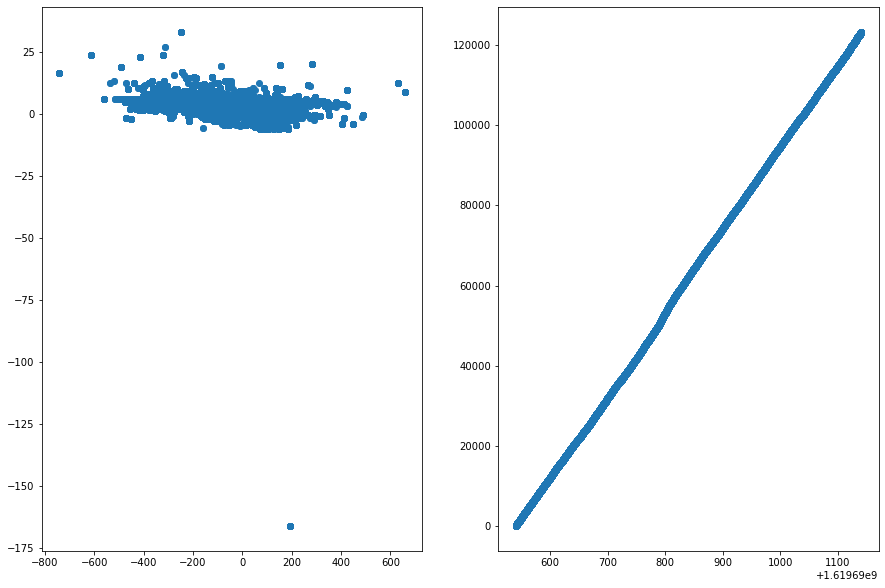

In [130]:
plt.figure(figsize = (15,10))
plt.subplot(1,2,1)
plt.scatter(hitpoints_df["hitObjectColliderBoundsCenter.x"], hitpoints_df["hitObjectColliderBoundsCenter.y"])
plt.subplot(1,2,2)
plt.scatter(hitpoints_df["timeStampDataPointStart"], range(0,len(hitpoints_df)))

In [28]:
print(hitpoint_list[0][1])
#print(pd.json_normalize(hitpoint_list[0]))

{'hitPointOnObject': {'x': -65.56773376464844, 'y': 1.1634469032287598, 'z': 81.047607421875}, 'hitObjectColliderName': 'terrain_S.001', 'hitObjectColliderBoundsCenter': {'x': -60.39029312133789, 'y': 1.153674840927124, 'z': 100.80474090576172}, 'ordinalOfHit': 2}


In [142]:
subject_pd['rayCastHitsCombinedEyes'].head()

0    [{'hitPointOnObject': {'x': -64.1910629272461, 'y': 1.429070234298706, 'z': 71.21446990966797}, 'hitObjectColliderName': 'pavement_O.002', 'hitObjectColliderBoundsCenter': {'x': -165.16314697265625, 'y': 1.4516879320144653, 'z': -15.555870056152344}, 'ordinalOfHit': 1}, {'hitPointOnObject': {'x': -65.56773376464844, 'y': 1.1634469032287598, 'z': 81.047607421875}, 'hitObjectColliderName': 'terrain_S.001', 'hitObjectColliderBoundsCenter': {'x': -60.39029312133789, 'y': 1.153674840927124, 'z': 100.80474090576172}, 'ordinalOfHit': 2}]          
1    [{'hitPointOnObject': {'x': -64.1910629272461, 'y': 1.429070234298706, 'z': 71.21446990966797}, 'hitObjectColliderName': 'pavement_O.002', 'hitObjectColliderBoundsCenter': {'x': -165.16314697265625, 'y': 1.4516879320144653, 'z': -15.555870056152344}, 'ordinalOfHit': 1}, {'hitPointOnObject': {'x': -65.56773376464844, 'y': 1.1634469032287598, 'z': 81.047607421875}, 'hitObjectColliderName': 'terrain_S.001', 'hitObjectColliderBoundsCenter': {'